In [1]:
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import bs4
import pymysql
import requests
from pandas import DataFrame,Series
import datetime


In [60]:
class Craweling(object):
    def __init__(self, url, idrange):
        self.url = url
        self.idrange = idrange
        self.idlist = set([]) # record of players who has been read
    
    # get raw text from a website page
    def getPage(self, i_d):
        s_i_d = str(i_d)
        r = requests.get(self.url + s_i_d)
        if not r.ok:
            print('connection error')
        return r
    
    # clean the raw text, return a dataframe
    def getPageItem(self, i_d):
        temp = self.getPage(i_d)
        #apply BeautifulSoup to generate a structured dataframe
        soup = BeautifulSoup(temp.text, "lxml")
        
        #athlete
        if not soup.find(name = 'h1'):
            return False
        athlete = soup.h1.string[11:]


        #score
        score_ = soup.find_all(text = re.compile(r'(-.+?,.+?-.+?)|(by default)'))
        w1,w2,w3,w4,w5=[],[],[],[],[]
        l1,l2,l3,l4,l5=[],[],[],[],[]
        wlset = []
        #split score to win/lose
        
        

        for score in score_:
            if not re.search(r'by default',score):
                temp = score.strip().split(',')
                w = [0]*5
                l = [0]*5
                count = 0
                for smallscore in temp:
                    splitscore = smallscore.strip().split('-')
                    w[count] = int(splitscore[0])
                    l[count] = int(splitscore[1])
                    count += 1
                wl = count
                w1.append(w[0]),w2.append(w[1]),w3.append(w[2]),w4.append(w[3]),w5.append(w[4])
                l1.append(l[0]),l2.append(l[1]),l3.append(l[2]),l4.append(l[3]),l5.append(l[4])
                wlset.append(wl)
            else:
                w1.append(0),w2.append(0),w3.append(0),w4.append(0),w5.append(0)
                l1.append(0),l2.append(0),l3.append(0),l4.append(0),l5.append(0)
                wlset.append(-1)
        d_score_error = ~(np.array(wlset)==-1) # delete score error


        #types 
        type_ = soup.find_all(text = re.compile(r'(\xa0\n.+Single|Double)|(en\'s.+Singles)'))
        
        
        d_types = []
        for t in np.array(type_):
            if re.search(r'Singles',t):
                d_types.append(True)  
            else:
                d_types.append(False)
        d_type_error = np.array(d_types)
        #d_type_error: a bool np.array. Singles value = True, doubles value = False. Drop doubles. 
       

        #names and result
        results_ = soup.find_all(text = re.compile(r'(def\.)|(lost to)'))
       

        #results of each game
        results = []

        #winner and loser :a list of the first player for each game. It Still has doubles.                 
        winner = []
        loser = []
        for t in results_:
            result = t.strip()
            results.append(result)
            name = t.find_next(href = re.compile(r'Players'))['href'][15:]
            if result == 'def.':
                winner.append(i_d)
                loser.append(name)
            else:
                winner.append(name)
                loser.append(i_d)
        win_n = np.array(winner,dtype = int)
        loss_n = np.array(loser,dtype = int)
        
        

        #dates
        #meets
        dates = []
        meets = []
        date_= soup.find_all(href = re.compile(r'MeetReport'))

        for date in date_:
            dates.append(datetime.datetime.strptime(date.string.strip(),"%m/%d/%Y"))
            meet_ = date.find_next(text = re.compile(r'[a-zA-Z]')).strip()
            meets.append(meet_)    
           
        date_n = np.array(dates,dtype=datetime.date)
        
        d_date_error = date_n > datetime.datetime.strptime("2001-10-01","%Y-%m-%d")
        
        data = {'Date':date_n, 'Meet':meets, 
                'Winner_id':win_n, "Loser_id":loss_n,
                "w1":w1,"w2":w3,"w3":w3,"w4":w4,"w5":w5,
                "l1":l1,"l2":l2,"l3":l3,"l4":l4,"l5":l5,
                "wl":wlset}
        
        #repeated records
        d_repeated = self.__repeated(win_n) & self.__repeated(loss_n)
        
        
        #drop the error and repeated records
        droperror = (d_type_error&d_score_error&d_date_error&d_repeated)
        df = DataFrame(data)[droperror]
#         df = DataFrame(data)
        
        # add this player in idlist
        self.idlist.add(int(i_d))
             
        return df
    
    
    def __repeated(self, ids):
        d_id = []
        for i in ids:
            if i in self.idlist:
                d_id.append(False)
            else:
                d_id.append(True)
        return np.array(d_id)

  
    
    
    
    
class Craweling_athlete(Craweling):
    def getPageItem():
        temp = self.getPage(i_d)
        #apply BeautifulSoup to generate a structured dataframe
        soup = BeautifulSoup(temp.text, "lxml")


   



In [70]:
crawlor = Craweling(url,13700)
cc = crawlor.getPageItem(1000)

In [79]:
4000%101

61

In [76]:
from sqlalchemy import create_engine


username = 'root'
password = 'bgzwosdfz0617..'
host = 'localhost:3306'
dbname = 'nctta_rating'

class DatabaseConnect(object):
    def __init__(self, username, password, host, dbname):
        self.DB_CON_STR = 'mysql+pymysql://' + username +':'\
        + password +'@'+ host +'/' + dbname +'?charset=utf8'
        self.engine = create_engine(self.DB_CON_STR, echo = False)
        
    def read(self, sql):
        return pd.read_sql(sql, con=self.engine)
    
    def write(self, df, table):
        if type(df) != bool:
            df.to_sql(table, self.engine, if_exists = 'append')
        
    def write_crawler(self, crawler, table):
        for i in range(1,crawler.idrange):
            if i%100 == 0:
                print(i)
            try:    
                df = crawler.getPageItem(i)
                self.write(df, table)
            except Exception as e:
                print('TypeErrror:', e)
                print(i)
            except ValueError as e:
                print('ValueError:', e)
                print(i)

 



In [77]:
#download score records to database

url = "http://danserver.com/nctta/IndivMatches.asp?id="
print(url)
crawlor = Craweling(url,13870)
DBC = DatabaseConnect(username, password, host, dbname)    
sql = "SELECT * FROM records;"
df = DBC.read(sql) 
df

http://danserver.com/nctta/IndivMatches.asp?id=


,Winner_id,Loser_id,Date,Meet,w1,w2,w3,w4,w5,l1,l2,l3,l4,l5,lw


In [80]:
DBC.write_crawler(crawlor,'score_history')

100
200
300
400
500
600
700
800
900
1000
TypeErrror: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
1065
TypeErrror: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
1068
1100
1200
1300
1400
1500
TypeErrror: invalid literal for int() with base 10: ''
1547
1600
TypeErrror: invalid literal for int() with base 10: ''
1634
1700
TypeErrror: invalid literal for int() with base 10: ''
1711
1800
TypeErrror: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
1815
1900
TypeErrror: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
1925
TypeErrror: invalid litera

In [81]:
result = DBC.read('Select * from score_history')
result.head()
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63565 entries, 0 to 63564
Data columns (total 16 columns):
index        63565 non-null int64
Date         63565 non-null datetime64[ns]
Loser_id     63565 non-null int64
Meet         63565 non-null object
Winner_id    63565 non-null int64
l1           63565 non-null int64
l2           63565 non-null int64
l3           63565 non-null int64
l4           63565 non-null int64
l5           63565 non-null int64
w1           63565 non-null int64
w2           63565 non-null int64
w3           63565 non-null int64
w4           63565 non-null int64
w5           63565 non-null int64
wl           63565 non-null int64
dtypes: datetime64[ns](1), int64(14), object(1)
memory usage: 7.8+ MB


In [85]:
result.describe()

,index,Loser_id,Winner_id,l1,l2,l3,l4,l5,w1,w2,w3,w4,w5,wl
count,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000,63565.000000
mean,16.461685,6820.574137,6636.212003,6.618721,6.758814,6.854322,2.678345,0.908204,10.696783,10.683647,10.683647,3.624794,1.380005,3.460222
std,19.088467,3608.322885,3603.769167,3.149664,3.100729,3.118587,4.084262,2.596708,1.603889,1.671685,1.671685,5.161201,3.728119,0.704372
min,0.000000,17.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,3.000000,3829.000000,3586.000000,4.000000,4.000000,5.000000,0.000000,0.000000,11.000000,11.000000,11.000000,0.000000,0.000000,3.000000
50%,10.000000,6849.000000,6569.000000,6.000000,7.000000,7.000000,0.000000,0.000000,11.000000,11.000000,11.000000,0.000000,0.000000,3.000000
75%,22.000000,9456.000000,9260.000000,9.000000,9.000000,9.000000,6.000000,0.000000,11.000000,11.000000,11.000000,11.000000,0.000000,4.000000
max,168.000000,13939.000000,13939.000000,48.000000,48.000000,23.000000,30.000000,35.000000,50.000000,25.000000,25.000000,32.000000,37.000000,5.000000


In [86]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\ll299\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


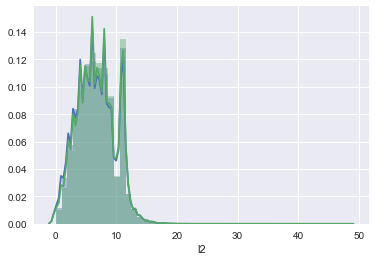